In [105]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import datetime as dt
import math
from scipy.stats import norm

In [106]:
ticker = 'GC=F'
#Gold - GC=F, Brent - BZ=F, Natural Gas - NG=F
startDate = '2025-01-01'
endDate = dt.datetime.now()
data = yf.download(ticker, startDate, endDate)
prices = data['Close']

[*********************100%***********************]  1 of 1 completed


In [107]:
Last_price = prices.tail(1)
Last_price

Ticker,GC=F
Date,
2025-02-21,2931.0


In [108]:
returns = np.log(prices/prices.shift(1))*100
returns = returns.dropna()

In [109]:
#GARCH(1,1) Model
model = arch_model(returns, vol='Garch', p=1, q=1)
results = model.fit(disp='off')
print(results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   GC=F   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -41.2946
Distribution:                  Normal   AIC:                           90.5892
Method:            Maximum Likelihood   BIC:                           96.8106
                                        No. Observations:                   35
Date:                Sun, Feb 23 2025   Df Residuals:                       34
Time:                        13:06:08   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2770      0.136      2.042  4.114e-02 [1.114e-0

In [110]:
forecast_horizon =11 #Days
forecasts = results.forecast(horizon=forecast_horizon)
forecasted_volatility = np.sqrt(forecasts.variance.dropna().iloc[-1])
print(f"Forecasted Volatility for the Next {forecast_horizon} Days (in%):")
print(forecasted_volatility)

Forecasted Volatility for the Next 11 Days (in%):
h.01    0.813842
h.02    0.814086
h.03    0.814311
h.04    0.814520
h.05    0.814713
h.06    0.814892
h.07    0.815058
h.08    0.815211
h.09    0.815353
h.10    0.815484
h.11    0.815606
Name: 2025-02-21 00:00:00, dtype: float64


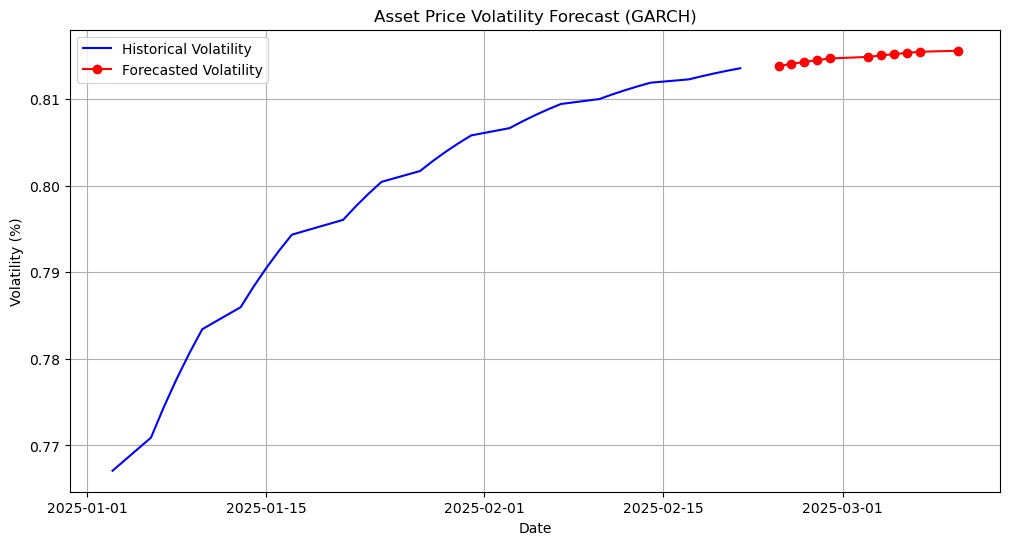

In [111]:
#Plot of Volatility
historical_volatility = results.conditional_volatility
plt.figure(figsize=(12, 6))
plt.plot(historical_volatility, label='Historical Volatility', color='blue')
forecast_dates = pd.date_range(start=returns.index[-1], periods=forecast_horizon + 1, freq='B')[1:]
plt.plot(forecast_dates, forecasted_volatility, label='Forecasted Volatility', color='red', marker='o')
plt.title('Asset Price Volatility Forecast (GARCH)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.show()

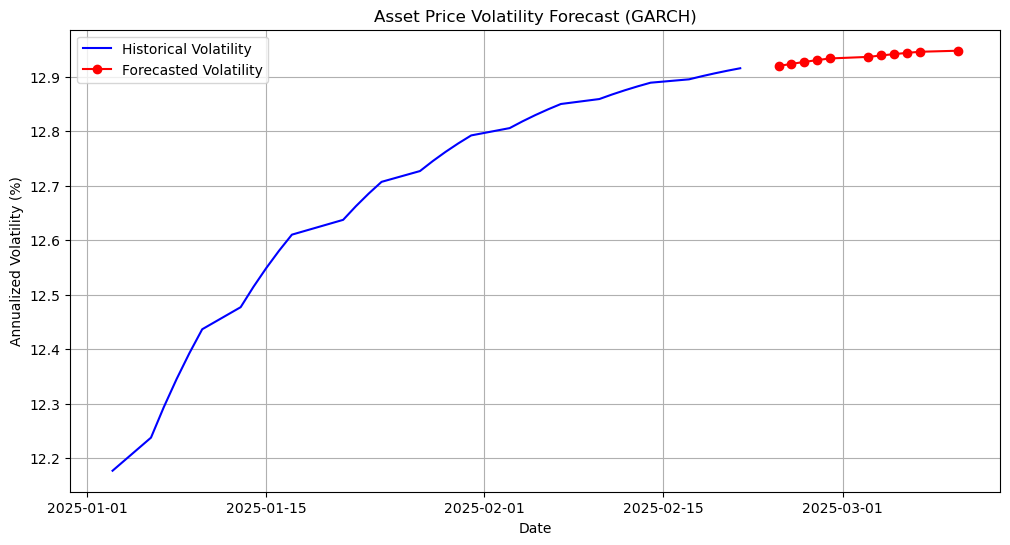

In [112]:
#Plot of Annualized Volatility
historical_volatility = results.conditional_volatility * np.sqrt(252)
plt.figure(figsize=(12, 6))
plt.plot(historical_volatility, label='Historical Volatility', color='blue')
forecast_dates = pd.date_range(start=returns.index[-1], periods=forecast_horizon + 1, freq='B')[1:]
plt.plot(forecast_dates, forecasted_volatility * np.sqrt(252), label='Forecasted Volatility', color='red', marker='o')
plt.title('Asset Price Volatility Forecast (GARCH)')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (%)')
plt.legend()
plt.grid(True)
plt.show()

In [113]:
#Option Parameters Call and Put (Please enter manually for each option) For example simulation I am using a European Premium Gold Option Traded on MOEX (06.03.2025)
S = 8355  # Current price of the underlying asset (For example calculation also used MOEX Gold Price)
K = 8400  # Strike price
C = 206  # Market price of the call option
P = 142.7   # Market price of the put option
T = 11 / 365  # Time to maturity in years
r = 0.21  # Risk-free rate

In [114]:
#Newton Raphson Parameters (linear approximation)
sigma = 0.5 #Initial guess with sigma 50%
tolerance = 1e-6
max_iterations = 1000

In [115]:
for i in range(max_iterations):
    # Calculate d1 and d2
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    # Calculate the Black-Scholes call and put price
    Cprice = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    Pprice = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    # Calculate vega 
    vega = S * norm.pdf(d1) * math.sqrt(T)
    
    # Update sigma using Newton-Raphson
    sigma2 = sigma - (Cprice - C) / vega
    sigma3 = sigma - (Pprice - P) / vega
    
    if abs(Cprice - C) < tolerance:
        break
    if abs(Pprice - P) < tolerance:
        break

In [116]:
ivC = sigma2*np.sqrt(252) #Annualized Implied Volatility Call
ivP = sigma3*np.sqrt(252) #Annualized Implied Volatility Put
garchv = forecasted_volatility.mean()*np.sqrt(252) #Annualized Mean of Daily GARCH Volatility Forecasts
hvol = returns.std()*np.sqrt(252) #Annualized Historical Volatility of an Asset
hisvol = hvol.values[0]
print(f"Annualized Historical Volatility of an Asset: {hisvol:.2f}%")
print(f"Annualized Implied Volatility Call: {ivC:.2f}%")
print(f"Annualized Implied Volatility Put: {ivP:.2f}%")
print(f"Annualized GARCH Forecast Volatility: {garchv:.4f}%")

Annualized Historical Volatility of an Asset: 12.70%
Annualized Implied Volatility Call: 5.54%
Annualized Implied Volatility Put: 4.02%
Annualized GARCH Forecast Volatility: 12.9349%


In [117]:
ivC = sigma2 #Implied Volatility Call
ivP = sigma3 #Implied Volatility Put
garchv = forecasted_volatility.mean() #Mean of Daily GARCH Volatility Forecasts
hvol = returns.std() #Historical Volatility of an Asset
hisvol = hvol.values[0]
print(f" Historical Volatility of an Asset: {hisvol:.2f}%")
print(f" Implied Volatility Call: {ivC:.2f}%")
print(f" Implied Volatility Put: {ivP:.2f}%")
print(f" GARCH Forecast Volatility: {garchv:.4f}%")

 Historical Volatility of an Asset: 0.80%
 Implied Volatility Call: 0.35%
 Implied Volatility Put: 0.25%
 GARCH Forecast Volatility: 0.8148%


In [118]:
#Option Premium Calculation Using GARCH Volatility
gd1 = (math.log(S/K) + (r + 0.5 * garchv**2)*T)/(garchv * math.sqrt(T))
gd2 = gd1-(garchv*math.sqrt(T))
gC = S * norm.cdf(gd1) - K * math.exp(-r*T) * norm.cdf(gd2)
gP = K * math.exp(-r*T)* norm.cdf(-gd2) - S * norm.cdf(-gd1)
print('GARCH Volatility Forecast Based European Option Prices at Expiration')
print('The value of d1 is: ', round(d1, 4))
print('The value of d2 is: ', round(d2, 4))
print('The price of the call option is:', round(gC, 2))
print('The price of the put option is:', round(gP, 2))

GARCH Volatility Forecast Based European Option Prices at Expiration
The value of d1 is:  0.0544
The value of d2 is:  -0.0324
The price of the call option is: 474.88
The price of the put option is: 466.88


In [146]:
#Analysis Section
pricech = gC-C #Diference in price between real market and simulation.
deltach = gd1-d1
if pricech > 0:
    print(f'The difference in price is {pricech:.2f}. It makes sense to use directional trading strategies.')
elif pricech == 0:
    print(f'No change in price of an option')
else:
    print(f'The difference in price is {pricech:.2f}. It makes sense to use directional trading strategies.')

if deltach >0:
    print(f'The difference in delta is {deltach:.2f} which means that the call option is {deltach*100:.2f}% more likely to expire in the money compared to initial probability.')
elif deltach ==0:
    print(f'There is no difference in delta.')
else:
    print(f'The difference in delta is {deltach:.2f} which means that the call option is {-deltach*100:.2f}% less likely to expire in the money compared to initial probability.')
print('For pure volatility trading dynamic delta hedging is required.')

The difference in price is 268.88. It makes sense to use directional trading strategies.
The difference in delta is 0.02 which means that the call option is 2.31% more likely to expire in the money compared to initial probability.
For pure volatility trading dynamic delta hedging is required.
